# chapter 09 로지스틱 회귀의 기초

### 로지스틱 회귀란? 일반적인 회귀 문제와는 다르게 몇 가지의 이산적인 값 중 하나를 선택하는 모델로, 흔히 '분류 모델'이라고 부른다.

## 02 분류 문제의 성능지표

#### 혼동행렬(confusion matrix): 예측값이 실제값 대비 얼마나 잘 맞는지 2x2 행렬로 표현하는 기법
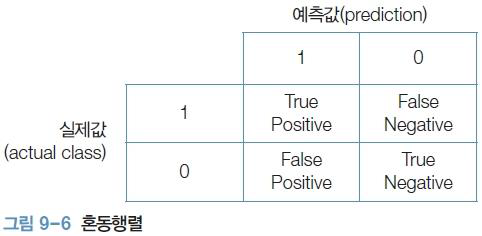
- TP(True Positive): 예측값과 실제값이 모두 1로 동일할 때, 즉 모델의 예측값이 정답이고 예측 대상이 1일 때
- TN(True Negative): 예측값과 실제값이 모두 0으로 동일할 때, 즉 모델의 예측값이 정답이고 예측 대상이 0일 때
- FN(False Negative): 실제값은 1이지만 예측값이 0이므로, 모델의 예측값이 오답이고 예측값이 0을 예측할 때
- FP(False Positive): 실제값은 0이지만 예측값이 1로, 모델의 예측값이 오답이고 예측값이 1을 예측할 때

In [1]:
from sklearn.metrics import confusion_matrix

y_true=[1,0,1,1,0,1] # 실제값
y_pred=[0,0,1,1,0,1] # 예측값
confusion_matrix(y_true,y_pred)

array([[2, 0],
       [1, 3]], dtype=int64)

넘파이 배열은 TN, FP, FN, TP 순서대로 출력된다.

In [2]:
tn, fp, fn, tp=confusion_matrix(y_true,y_pred).ravel()
(tn,fp,fn,tp)

(2, 0, 1, 3)

##### 정확도(accuracy): 전체 데이터 개수 개비 정답을 맞춘 데이터의 개수 -> (TP + TN) / (TP + TN + FP + FN)

In [4]:
import numpy as np
from sklearn.metrics import accuracy_score

y_pred=np.array([0,1,1,0]) # 예측값
y_true=np.array([0,1,0,0]) # 실제값

In [5]:
sum(y_true==y_pred)/len(y_true) # 정답을 맞춘 개수/전체 데이터

0.75

In [6]:
accuracy_score(y_true,y_pred)

0.75

##### 정밀도(precision): 모델이 1이라고 예측했을 때 얼마나 잘 맞을지에 대한 비율 -> TP / (TP + FP)
##### 민감도(recall): 실제 1인 값을 가진 데이터를 모델이 얼마나 1이라고 잘 예측했는지에 대한 비율 -> TP / (TP + FN)
##### F1 스코어(F1 score): 정밀도와 민감도를 통합한 지표로 정밀도와 민감도의 조화평균 값 -> 2 x (presicon x recall) / (precision + recall)

In [9]:
import numpy as np
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

y_pred=np.array([0,1,1,0,1,1,1,0]) # 예측값
y_true=np.array([0,1,0,0,0,0,1,1]) # 실제값

In [10]:
precision_score(y_true,y_pred) # 정밀도

0.4

In [11]:
recall_score(y_true,y_pred) # 민감도

0.6666666666666666

In [12]:
f1_score(y_true,y_pred) # f1 스코어

0.5

## 03 로지스틱 회귀 구현하기

##### 인터넷 사용자가 뉴비(newbie)인지 아닌지를 구별하는 와튼대학교의 'uva.txt' 데이터

In [14]:
import pandas as pd
data_url='http://www-stat.wharton.upenn.edu/~waterman/DataSets/uva.txt'

df=pd.read_table(data_url)
df[:5]

,who,Newbie,Age,Gender,Household Income,Sexual Preference,Country,Education Attainment,Major Occupation,Marital Status,Years on Internet
0,id74364,0,54.0,Male,$50-74,Gay male,Ontario,Some College,Computer,Other,4-6 yr
1,id84505,0,39.0,Female,Over $100,Heterosexual,Sweden,Professional,Other,Other,1-3 yr
2,id84509,1,49.0,Female,$40-49,Heterosexual,Washington,Some College,Management,Other,Under 6 mo
3,id87028,1,22.0,Female,$40-49,Heterosexual,Florida,Some College,Computer,Married,6-12 mo
4,id76087,0,20.0,Male,$30-39,Bisexual,New Jersey,Some College,Education,Single,1-3 yr


불러들인 데이터를 보면 여러 개의 변수가 존재한다.

데이터 전처리를 위해 who, country, Years on Internet 열을 제거한다.

In [15]:
df.pop('who')
df.pop('Country')
df.pop('Years on Internet')
# 필요없는 열 삭제
df.dtypes

Newbie                    int64
Age                     float64
Gender                   object
Household Income         object
Sexual Preference        object
Education Attainment     object
Major Occupation         object
Marital Status           object
dtype: object

category 타입의 데이터들에 대해서 원핫인코딩 형태로 바꾸기 위해 데이터의 타입을 category로 변화시킨다.

In [17]:
category_cols=['Gender','Household Income','Sexual Preference','Education Attainment','Major Occupation','Marital Status']
for col in category_cols:
    df[col]=df[col].astype('category') # category 타입으로 바꾸기
    
df.dtypes

Newbie                     int64
Age                      float64
Gender                  category
Household Income        category
Sexual Preference       category
Education Attainment    category
Major Occupation        category
Marital Status          category
dtype: object

In [18]:
df_onehot=pd.get_dummies(df) # 원핫인코딩을 통해 38개의 열이 됨
df_onehot.shape

(19583, 38)

In [23]:
df_onehot.head(5).T

,0,1,2,3,4
Newbie,0.0,0.0,1.0,1.0,0.0
Age,54.0,39.0,49.0,22.0,20.0
Gender_Female,0.0,1.0,1.0,1.0,0.0
Gender_Male,1.0,0.0,0.0,0.0,1.0
Household Income_$10-19,0.0,0.0,0.0,0.0,0.0
Household Income_$20-29,0.0,0.0,0.0,0.0,0.0
Household Income_$30-39,0.0,0.0,0.0,0.0,1.0
Household Income_$40-49,0.0,0.0,1.0,1.0,0.0
Household Income_$50-74,1.0,0.0,0.0,0.0,0.0
Household Income_$75-99,0.0,0.0,0.0,0.0,0.0


데이터의 결측값을 확인한다.

isnull 함수를 사용하여 각 열별 데이터 중 isnull 함수 결과의 합을 구해 보여준다.

그 결과 Age 열에만 결측값이 존재하는 것을 확인할 수 있다.

In [19]:
df_onehot.isnull().sum() # 결측치 확인 

Newbie                                 0
Age                                  561
Gender_Female                          0
Gender_Male                            0
Household Income_$10-19                0
Household Income_$20-29                0
Household Income_$30-39                0
Household Income_$40-49                0
Household Income_$50-74                0
Household Income_$75-99                0
Household Income_Over $100             0
Household Income_Under $10             0
Sexual Preference_Bisexual             0
Sexual Preference_Gay male             0
Sexual Preference_Heterosexual         0
Sexual Preference_Lesbian              0
Sexual Preference_Transgender          0
Sexual Preference_na                   0
Education Attainment_College           0
Education Attainment_Doctoral          0
Education Attainment_Grammar           0
Education Attainment_High School       0
Education Attainment_Masters           0
Education Attainment_Other             0
Education Attain

loc 함수를 사용하여 Age 열의 빈칸을 Age의 평균값으로 채운다.

In [20]:
df_onehot.loc[pd.isnull(df_onehot['Age']),'Age']=df_onehot['Age'].mean() # Age 열의 빈칸을 찾아 Age의 평균값으로 채우기

데이터를 x 데이터와 y 데이터로 나눈 후, 이를 다시 train 데이터와 test 데이터로 분류한다.

Newbie열은 y_data에 할당하고, 나머지는 x_data에 할당한다.

In [24]:
x_data=df_onehot.iloc[:,1:].values # 1열부터 x_data
y_data=df_onehot.iloc[:,0].values.reshape(-1,1) # 0열만 y_Data
y_data.shape,x_data.shape

((19583, 1), (19583, 37))

x_data에 대해서 MinMaxScaler 함수를 사용하여 전체 데이터에 대한 스케일링을 실시한다.

In [26]:
from sklearn import preprocessing

min_max_scaler=preprocessing.MinMaxScaler()
x_data=min_max_scaler.fit_transform(x_data)

train-test split 함수를 적용하여 생성된 데이터를 학습 데이터셋과 테스트 데이터셋으로 분리한다.

In [28]:
from sklearn.model_selection import train_test_split

# 학습 데이터셋과 테스트 데이터셋으로 분리하기
X_train, X_test, y_train, y_test=train_test_split(x_data,y_data,test_size=0.33,random_state=42)
X_train.shape, X_test.shape

((13120, 37), (6463, 37))

최종적으로 LogisticRegression 클래스를 사용하여 학습된 모델을 생성한다.

In [30]:
from sklearn.linear_model import LogisticRegression

logreg=LogisticRegression(fit_intercept=True)
logreg.fit(X_train,y_train.flatten()) # 학습

LogisticRegression()

In [37]:
LogisticRegression(C=1.0, class_weight=None, dual=False,
                  fit_intercept=True, intercept_scaling=1,
                  l1_ratio=None, max_iter=100, multi_class='warn',
                  n_jobs=None, penalty='l2',random_state=None,
                  solver='warn',tol=0.0001, verbose=0,
                  warm_start=False)

LogisticRegression(multi_class='warn', solver='warn')

생성된 모델을 사용하여 실제값을 예측하기 위해 predict 함수를 사용한다.

In [38]:
logreg.predict(X_test[:5]) # 테스트

array([0, 0, 0, 0, 0], dtype=int64)

predict_proba 함수는 각각 0일 떄의 확률과 1일 때의 확률을 nx2형태의 행렬로 나타낸다.

In [39]:
logreg.predict_proba(X_test[:5]) # 확률예측

array([[0.56843258, 0.43156742],
       [0.91112572, 0.08887428],
       [0.79481085, 0.20518915],
       [0.85841562, 0.14158438],
       [0.62764603, 0.37235397]])

실제 성능 측정을 위해 confusion_matrix와 accuracy_score 함수를 사용한다.

y_true 변수에는 실제값인 y_test 값을 복사하고, y_pred에는 모델로 예측된 값들을 할당한다.

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_true=y_test.copy()
y_pred=logreg.predict(X_test)
confusion_matrix(y_true,y_pred) # 혼동행렬

array([[4487,  275],
       [1350,  351]], dtype=int64)

In [41]:
accuracy_score(y_true, y_pred) # 정확도

0.7485687761101656

# chapter10 로지스틱 회귀의 심화

### 01 다중클래스 분류와 소프트맥스 분류
#### 다중클래스분류: 2개 이상의 클래스를 가진 y값에 대한 분류
#### 소프트맥스 함수: 다중 클래스 분류에서 여러 선형회귀의 출려 결과를 정규화하여 합이 1이 되도록 만드는 함수

In [45]:
import numpy as np

def softmax(values):
    array_values=np.exp(values)
    print(array_values, np.sum(array_values))
    return array_values/np.sum(array_values)

values=[2,1,5,0.5]
y=softmax(values) # array([0,04613281,0.01697131,0.92660226,0.01029362])
y.sum()

[  7.3890561    2.71828183 148.4131591    1.64872127] 160.16921830066642


1.0

### 02 다중클래스 분류를 코드로 구현하기

#### mnist 데이터셋: 다양한 데이터셋 중 손글씨를 숫자로 인식하는 이미지 분류 문제
- 색깔이 진할수록 공간 안에서 높을 값을 가지고 색깔이 옅을수록 낮은 값을 가진다고 이해할 수 있다.

사이킷런의 데이터 불러오기
- 데이터는 data 키 값에
- y값에 해당하는 값은 target에 있다.

In [47]:
from sklearn import datasets
digit_dataset=datasets.load_digits()
digit_dataset.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [48]:
digit_dataset['images'].shape # 1797개의 8행 8열 데이터

(1797, 8, 8)

In [49]:
digit_dataset['target'][0] # target의 0번째 데이터는 0이다

0

In [50]:
digit_dataset['images'][0] # images 데이터의 0번째 값

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

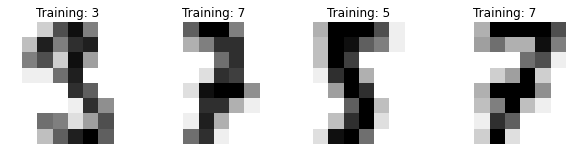

In [53]:
import matplotlib.pyplot as plt
from random import randint
_, axes=plt.subplots(nrows=1,ncols=4,figsize=(10,3)) # 1행 4열

for ax in axes:
    num=randint(1,1000) # 1에서 1000까지의 숫자 중 랜덤으로 1개 선정
    image=digit_dataset['images'][num]
    label=digit_dataset['target'][num]
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r,interpolation='nearest') # interpolation: 보간법(픽셀들의 축 위치 간격을 보정하여 이미지가 자연스러운 모양으로 보일 수 있게 하는 방법)
    ax.set_title('Training: %i' % label)

In [54]:
digit_dataset['data'][0].shape # 하나의 데이터는 8행 8열 -> 64개의 feature로 구성되어 있다.

(64,)

데이터 분류하기
- data와 target에 있는 값을 각각 x와 y 변수에 할당한다.
- train_test_split으로 훈련 데이터셋과 테스트 데이터셋으로 구분하여 데이터 x와 y를 각 변수에 할당한다.

In [57]:
from sklearn.model_selection import train_test_split

X=digit_dataset['data']
y=digit_dataset['target']
X_train,X_test,y_train,y_test=train_test_split(X,y) # 훈련 데이터셋과 테스트 데이터셋으로 구분하기

모델 생성하기
- ovr: 각각의 클래스 모드를 모두 이진모델(binary model)로 만들어 학습하는 방식
- multinomal: 소프트맥스 함수(softmax function)를 사용하여 계산하는 방식으로, 해당 학습을 위해서 경사하강법을 사용하는 매개변수 solver를 sag으로 변경해야 한다.

In [60]:
from sklearn.linear_model import LogisticRegression
# 모델 생성
logreg_ovr=LogisticRegression(multi_class='ovr')
logreg_softmax=LogisticRegression(multi_class='multinomial',solver='sag') 
# 모델 학습
logreg_ovr.fit(X_train,y_train)
logreg_softmax.fit(X_train,y_train)

C:\Users\user\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

LogisticRegression(multi_class='multinomial', solver='sag')

성능 측정하기

In [62]:
from sklearn.metrics import confusion_matrix
y_pred=logreg_ovr.predict(X_test).copy() # 예측
y_true=y_test.copy()
confusion_matrix(y_true,y_pred) # 혼동행렬로 표현

array([[41,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 50,  0,  1,  0,  0,  0,  0,  1,  0],
       [ 0,  0, 44,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  1, 42,  0,  1,  0,  0,  0,  0],
       [ 0,  2,  0,  0, 44,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0, 48,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  1, 45,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 41,  0,  2],
       [ 0,  3,  0,  0,  0,  0,  1,  0, 40,  1],
       [ 1,  0,  0,  0,  0,  1,  0,  1,  1, 34]], dtype=int64)

classification_report 함수를 사용하여 라벨별로 분류 성능 표시

In [64]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred)) # 라벨별 분류성능 표시

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        41
           1       0.91      0.96      0.93        52
           2       0.98      0.98      0.98        45
           3       0.98      0.95      0.97        44
           4       1.00      0.94      0.97        47
           5       0.94      0.98      0.96        49
           6       0.98      0.98      0.98        46
           7       0.95      0.95      0.95        43
           8       0.91      0.89      0.90        45
           9       0.92      0.89      0.91        38

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



In [65]:
result=confusion_matrix(y_true,y_pred)
result.diagonal().sum() / result.sum(axis=0).sum()

0.9533333333333334

- 만약, 라벨들의 데이터 개수가 차이나면 micro를 선택하여 얻는 결과가 더 중요하고,
- 그렇지 않을 경우는 macro로 선택하여 라벨의 평균적인 성능을 나타낼 수 있다.

In [66]:
from sklearn.metrics import precision_score
precision_score(y_true,y_pred,average='micro') # 전체 평균 성능

0.9533333333333334

In [67]:
precision_score(y_true,y_pred,average='macro') # 각 라벨별 평균 성능

0.9540738889361979

In [68]:
precision_score(y_true,y_pred,average=None)

array([0.97619048, 0.90909091, 0.97777778, 0.97674419, 1.        ,
       0.94117647, 0.97826087, 0.95348837, 0.90909091, 0.91891892])

### 03 ROC 커브와 AUC
#### ROC 커브는 TPR(True Positive Rate)과 FPR(FalsePositive Rate)을 각각 y축, x축에 나타내어 그래프를 작성한다.
- TPR=TP/TP+FN
- FPR=FP/FP+TN

#### ROC 커브 하단의 넓이를 AUC(Area Under Curve)라고 부르는데, 이 값을 사용하여 모델의 성능을 측정하기도 한다.

##### 사이킷런으로 ROC 커브와 AUC 계산하기
정답을 의미하는 y값과 각 항목별 예측 확률을 scores에 저장하고,

ROC 커브 함수인 roc_curve를 사용하면 fpr과 tpr과 함께 thresholds 값을 반환한다.

In [1]:
import numpy as np
from sklearn import metrics

y=np.array([1,1,2,2])
scores=np.array([0.1,0.4,0.35,0.8])
fpr, tpr, thresholds=metrics.roc_curve(y,scores,pos_label=2)

auc함수를 사용하여 auc 점수를 반환한다.

In [2]:
y=np.array([1,1,2,2])
pred=np.array([0.1,0.4,0.35,0.8])
fpr,tpr,thresholds=metrics.roc_curve(y,pred,pos_label=2)
roc_auc=metrics.auc(fpr,tpr)
roc_auc

0.75

ROC 커브 그리기

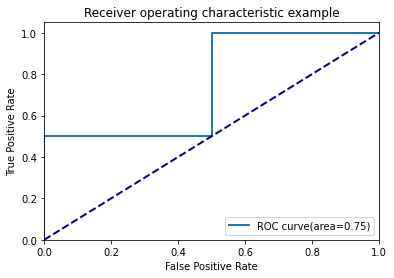

In [5]:
import matplotlib.pyplot as plt

plt.figure()
lw=2
plt.plot(fpr,tpr, lw=lw,label='ROC curve(area=%0.2f)'%roc_auc)
plt.plot([0,1],[0,1],color='navy',lw=lw,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc='lower right') # 오른쪽 아래에 범례 표시
plt.show()